In [829]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy.printing.octave import print_octave_code
from torch.ao.quantization.utils import check_node

from Problems import DTLZ2

## Problem Class

In [830]:
class FunctionalProblem:
    def __init__(self, n_var=1, objs=list, lb=0., ub=1.):
        self.n_var = n_var
        self.objs = objs
        self.n_dim = len(objs)
        self.lb = lb
        self.ub = ub

    def evaluate(self, X):
        """
        Evaluate the objective functions for a given population.

        :param X:
        :return:
        """

        F = np.zeros((X.shape[0], len(self.objs)))
        for i, x in enumerate(X):
            for j, obj in enumerate(self.objs):
                F[i][j] = obj(x)

        return F


### Hypervolume Calculation

In [831]:
from pymoo.indicators.hv import HV

def hypervolume(points, ref):
    n, d = points.shape

    if n == 0:
        return 0.0
    if d == 1:
        # 1D case: sum lengths of intervals
        return np.max(ref[0] - points[:, 0])

    # Sort by last dimension (d-th)
    sorted_indices = np.argsort(points[:, -1])
    points = points[sorted_indices]

    volume = 0.0
    prev = ref[-1]

    while len(points) > 0:
        # Take the last point (largest in last dimension)
        p = points[-1]
        height = prev - p[-1]

        # Slice space below this point
        below = points[points[:, -1] < p[-1]]
        if len(below) > 0:
            sub_volume = hypervolume(below[:, :-1], ref[:-1])
        else:
            sub_volume = np.prod(ref[:-1] - p[:-1])  # base case: box to ref

        volume += sub_volume * height
        prev = p[-1]
        points = points[:-1]

    return volume



## Individual Class

In [832]:
class Individual:
    def __init__(self):
        self.X = None
        self.F = None
        self.CD = None
        self.front = None

    def reset_crowding_distance(self):
        self.crowding_distance = 0.0

    def reset_front(self):
        self.front = 0

    def setX(self, X):
        self.X = X

    def setF(self, F):
        self.F = F

    def getX(self):
        return self.X

    def getF(self):
        return self.F


## Population Class

In [833]:
class Population:
    def __init__(self, pop_size=100):
        self.pop_size = pop_size
        self.pop = np.array([Individual() for _ in range(pop_size)])

    def initialise_population(self, problem):
        X = np.random.uniform(problem.lb, problem.ub, (self.pop_size, problem.n_var))
        for i, ind in enumerate(self.pop):
            ind.setX(X[i])


    def set_population(self, inds: [Individual]):
        assert len(inds) == self.pop_size, f"Population size mismatch. Got {len(inds)} individuals. Expected {self.pop_size}."
        self.pop = inds

    def set_decision_vectors(self, X):
        assert len(X) == self.pop_size

        for i, ind in enumerate(self.pop):
            ind.setX(X[i])

    def set_objectives(self, F):
        assert len(F) == self.pop_size
        for i, ind in enumerate(self.pop):
            ind.setF(F[i])


    def get(self, var):
        if var == "X":
            return np.array([ind.getX() for ind in self.pop])
        elif var == "F":
            return np.array([ind.getF() for ind in self.pop])
        else:
            raise ValueError("Invalid variable name.")

    def crowding_distance(self, front):
        """
        Calculate the crowding distance for a front of individuals.
        """

        if len(front) == 0:
            return

        num_objectives = len(front[0].F)

        for ind in front:
            ind.reset_crowding_distance()

        for m in range(num_objectives):
            # Sort them by their objective vector values
            front.sort(key=lambda ind: ind.F[m])

            # Extreme values have infinite crowding distance
            front[0].crowding_distance = front[-1].crowding_distance = 5e2


            min_f = front[0].F[m]
            max_f = front[-1].F[m]

            if max_f == min_f:
                continue

            for i in range(1, len(front) - 1):
                front[i].crowding_distance += (front[i + 1].F[m] - front[i - 1].F[m]) / (max_f - min_f)


    def non_dominated_sort(self):
        """
        Perform non-dominated sorting on the population.
        :return: List of fronts, where each front is a list of Individuals.
        """
        def ndf(population):
            points = np.array([ind.F for ind in population])
            A = points[:, np.newaxis, :]
            B = points[np.newaxis, :, :]

            better_or_equal = np.all(B <= A, axis=2)
            strictly_better = np.any(B < A, axis=2)
            dominated = better_or_equal & strictly_better
            np.fill_diagonal(dominated, False)

            return ~np.any(dominated, axis=1)

        for ind in self.pop:
            ind.reset_front()

        fronts = []
        data = self.pop[:]
        front_number = 0

        while len(data) > 0:
            f = ndf(data)
            front = [data[i] for i in range(len(data)) if f[i]]
            fronts.append(front)
            data = [data[i] for i in range(len(data)) if not f[i]]

            for ind in front:
                ind.front = front_number
            front_number += 1

        return fronts

    def crowded_tournament_selection(self):
        """
        Perform crowded tournament selection to select parents for crossover.

        :return: Selected parents
        """
        fronts = self.non_dominated_sort()
        for front in fronts:
            self.crowding_distance(front)

        selected = []
        while len(selected) < self.pop_size:
            individuals = np.random.choice(self.pop, 2, replace=True)


            if individuals[0].front < individuals[1].front:
                selected.append(individuals[0])
            elif individuals[0].front > individuals[1].front:
                selected.append(individuals[1])
            else:
                if individuals[0].crowding_distance > individuals[1].crowding_distance:
                    selected.append(individuals[0])
                else:
                    selected.append(individuals[1])

        return selected


    def eliminate_duplicates(self, eps=1e-16):
        """
        Remove duplicate individuals from the population.
        :param pop:
        :param pop_size:
        :param eps:
        :return:
        """

        X = np.array([ind.getX() for ind in self.pop])
        distances = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
        np.fill_diagonal(distances, np.inf)

        duplicates = np.any(distances < eps, axis=1)

        unique_indices = np.where(~duplicates)[0]
        self.pop = self.pop[unique_indices]
        self.pop_size = len(self.pop)



    def merge(self, other):
        """
        Merge two populations.
        """
        self.pop = np.concatenate([self.pop, other.pop])
        self.pop_size = len(self.pop)

        return self

    def difference_based_termination(self, prev_pop, reference_point, eps=1e-5):
        """
        Check if the population has changed significantly compared to the previous generation.
        """
        current_X = self.get("F")
        prev_X = prev_pop.get("F")

        hv_current = hypervolume(current_X, reference_point)
        hv_prev = hypervolume(prev_X, reference_point)

        diff = hv_current - hv_prev

        print("Difference:", diff)
        if diff < eps:
            return True
        return False



## Genetic Operators
- #### Simulated Binary Crossover (SBX)
- #### Polynomial Mutation



In [834]:
def sbx_crossover(parents, eta_c=2, crossover_prob=0.9, lb=0., ub=1.):
    """
    Perform Simulated Binary Crossover (SBX) on a given parent population.

    Args:
        parents np.ndarray: Parent population of shape (N, D), where N is the number of parents,
                                 and D is the number of genes per individual.
        eta_c (float): Distribution index that controls the spread of offspring.
        crossover_prob (float): Probability of performing crossover.

    Returns:
        numpy.ndarray: Offspring population of the same shape as parents.
    """

    """if parents.shape == (parents.shape[0], ):
        parents = np.reshape(parents, (parents.shape[0], 1))"""

    if parents.ndim == 1:
        parents = parents.reshape(-1, 1)


    num_parents, num_genes = parents.shape
    offspring = np.copy(parents)

    for i in range(0, num_parents - 1, 2):  # Pairwise crossover
        if np.random.rand() < crossover_prob:
            p1, p2 = parents[i], parents[i + 1]
            c1, c2 = np.copy(p1), np.copy(p2)


            for j in range(num_genes):
                u = np.random.rand()
                if u < 0.5:
                    beta_q = np.power((2 * u), (1 / (eta_c + 1)))
                else:
                    beta_q = np.power((1 / (2 * (1 - u))), (1 / (eta_c + 1)))

                c1[j] = (0.5 * (1 + beta_q) * p1[j] + (1 - beta_q) * p2[j])
                c2[j] = (0.5 * (1 - beta_q) * p1[j] + (1 + beta_q) * p2[j])

                c1 = np.clip(c1, lb, ub)
                c2 = np.clip(c2, lb, ub)

            offspring[i], offspring[i + 1] = c1, c2

    return offspring


def polynomial_mutation(X, prob, eta, xl, xu):
    """
    Perform polynomial mutation on a given population.

    Args:
        X np.ndarray: Population of shape (N, D), where N is the number of individuals,
                      and D is the number of genes per individual.
        prob (float): Mutation rate.
        eta (int): Mutation distribution index.
        xl (float): Lower bound of the gene.
        xu (float): Upper bound of the gene.

    Returns:
        np.ndarray: Mutated population of the same shape as X.
    """

    xl = np.array([xl for _ in range (X.shape[1])])
    xu = np.array([xu for _ in range (X.shape[1])])

    mut = np.random.rand(X.shape[0]) < prob
    _X = np.copy(X)

    for i, x in enumerate(X):
        if mut[i]:
            delta_1 = (x - xl) / (xu - xl)
            delta_2 = (xu - x) / (xu - xl)

            r = np.random.rand(1)
            if r <= 0.5:
                dq1 = (2. * r) + ( (1. - (2 * r)) * np.power((1 - delta_1), (eta + 1)))

                delta_q = (np.power(dq1, 1 / (eta + 1))) - 1
                #delta_q = (2 * r + (1 - 2 * r) * (1 - delta_1) ** (eta + 1)) ** (1 / eta + 1) - 1
            else:

                dq1 = (2. * (1. - r)) + ((2. * (r - 0.5)) *  np.power((1. - delta_2), (eta + 1)))
                delta_q = 1 - np.power(dq1, 1 / (eta + 1))

                #delta_q = 1 - (2 * (1 - r) + 2 * (r - 0.5) * (1 - delta_2) ** eta + 1) ** (1 / (eta + 1))

            x_mutated = x + (delta_q * (xu - xl))

            x_mutated = np.clip(x_mutated, xl, xu)

            _X[i] = x_mutated

    return _X

def genetic_opertation(parents, eta_c=15, crossover_prob=0.9, mutation_rate=0.1, eta_m=20, lb=-2., ub=2.):
    """
    Perform genetic operations (crossover and mutation) on a given parent population.

    Args:
        parents Population: Parent population
        eta_c (float): Distribution index that controls the spread of offspring.
        crossover_prob (float): Probability of performing crossover.
        mutation_rate (float): Probability of mutating a gene.
        eta_m (int): Mutation distribution index.
        lb (float): Lower bound of the gene.
        ub (float): Upper bound of the gene.

    Returns:
        numpy.ndarray: Offspring population of the same shape as parents.
    """

    parents = parents.get("X")

    crossover_offspring = sbx_crossover(parents, eta_c, crossover_prob)

    mutated_offspring = np.array(polynomial_mutation(crossover_offspring, mutation_rate, eta_m, lb, ub))

    offspring = Population(pop_size=len(parents))
    offspring.set_decision_vectors(mutated_offspring)

    return offspring

## Elitism Selection

In [835]:
def elitism(parents: Population, offspring: Population, pop_size=100):
    """
    Perform elitism selection to select the next generation.

    Args:
        parents Population: Parent population of shape (N, D), where N is the number of parents,
                                 and D is the number of genes per individual.
        offspring Population: Evaluated Offspring population of the same shape as parents.

    Returns:
        next_generation Population: Next generation population.
    """


    offspring.eliminate_duplicates()
    combined_population = parents.merge(offspring)
    fronts = combined_population.non_dominated_sort()

    next_generation = []

    for f in fronts:
        if len(next_generation) + len(f) > pop_size:
            combined_population.crowding_distance(f)

            f.sort(key=lambda ind: ind.crowding_distance, reverse=True)

            next_generation.extend(f[:pop_size - len(next_generation)])
        else:
            next_generation.extend(f)

    next_gen = Population(pop_size=pop_size)
    next_gen.set_population(next_generation)

    return next_gen

In [836]:
def run(n_gen, pop_size, problem, lb, ub, reference_point):

    pop = Population(pop_size=pop_size)
    prev_pop = pop
    pop.initialise_population(problem)
    pop.set_objectives(problem.evaluate(pop.get("X")))

    gen = 0
    terminate_on_difference = False

    while gen < n_gen:
        prev_pop = pop
        # Perform crowded tournament selection to select parents
        parents = Population(pop_size=pop_size)
        parents.set_population(pop.crowded_tournament_selection())

        # Perform Crossover and mutation to generate offspring
        offspring = genetic_opertation(parents, lb=lb, ub=ub)

        # Evaluate the offspring
        offspring.set_objectives(problem.evaluate(offspring.get("X")))

        # Use Non-dominated sorting and crowded distance to select the next generation
        pop = elitism(parents, offspring, pop_size)

        gen += 1
        print(f"Generation {gen} completed.")

        if gen % 2 == 0:
            if pop.difference_based_termination(prev_pop, reference_point, eps=.01):
                break

    return pop


Generation 1 completed.
Generation 2 completed.
Difference: -0.006764610816671457


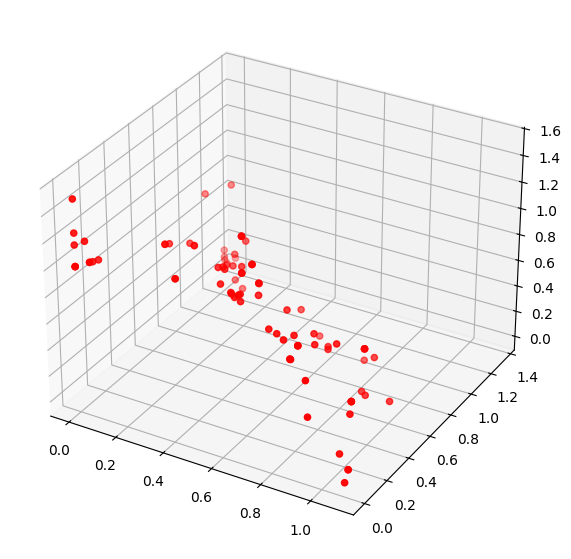

In [837]:
objs = [
    lambda x: np.sum((x - 2) ** 2),
    lambda x: np.sum((x + 2) ** 2)
]

lb=0
ub=1

reference_point = [2., 2., 2.]
#problem = FunctionalProblem(n_var=2, objs=objs, lb=lb, ub=ub)
problem = DTLZ2(n_var=5, n_obj=3)

pop = run(30, 100, problem, lb, ub, reference_point)

F = np.array(pop.get("F"))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(projection='3d')
ax.scatter(F[:, 0], F[:, 1], F[:, 2], c='r', marker='o')
plt.show()